<a href="https://colab.research.google.com/github/RCPernillo/Java_Practice/blob/master/7690_14_10616_Jose_Ramirez_Practica_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segunda práctica: Aspectos prácticos de las redesneuronales

En este segundo trabajo, vamos a continuar desarrollando el problema de Fashion MNIST, con el objetivo de entender los aspectos prácticos del entrenamiento de redes neuronales que hemos visto en el Tema 4.

El código utilizado para contestar tiene que quedar claramente reflejado en el Notebook. Puedes crear nuevas cells si así lo deseas para estructurar tu código y sus salidas. A la hora de entregar el notebook, **asegúrate de que los resultados de ejecutar tu código han quedado guardados**. 

In [ ]:
# Puedes añadir todos los imports adicionales que necesites aquí
import keras
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
import tensorflow as tf
import time
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

#### Obtención de los datos y pre-processing

In [ ]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

4431872/4422102 [==============================] - 0s 0us/step


## Consideraciones iniciales

### Train-validation-test split

En todos los modelos que entrenemos, vamos a partir los datos de training (x_train) en dos sets: training y validación. De este modo, al final tendremos tres datasets distintos: training, validation, y test. Esta es una estrategia común en el aprendizaje automático, en la que los datos de test (o held-out data) se 
"esconden" hasta el final. Los datos de validación se utilizan para estimar cómo de bien están funcionando nuestros modelos y para observar si estamos cayendo en overfitting. Esto nos permite cambiar hiperparámetros y probar distintas arquitecturas **sabiendo que no estamos utilizando información del test set para "optimizar" los resultados en éste** (si eligiéramos nuestro mejor modelo en base a los resultados de test, estaríamos "haciendo trampas", ya que se ha utilizado la información contenida en éste para elegir el modelo y las métricas reportadas serían optimistas).

Para utilizar un split training-validation data durante el entrenamiento, podemos partir nosotros mismos los datos o dejar que Keras lo haga. Podéis ver cómo hacer estas particiones en la documentación de *fit*.

**Requisito: En todos los entrenamientos de esta práctica, se requiere utilizar el 20% de los datos en x_train como  conjunto de datos de validación**

### Un error común con modelos de Keras

En esta práctica entrenaremos varios modelos para comparar resultados. Un error común en Keras es no instanciar un nuevo modelo cada vez que hacemos un nuevo entrenamiento. Al hacer

```
model = Sequential()

model.add(lo que sea)  # Definición del modelo

model.fit()

```


si queremos entrenar un nuevo modelo o el mismo modelo otra vez, es necesario volver a inicializar el modelo con model = Sequential(). Si olvidamos este paso y volvemos a hacer fit(), el modelo seguirá entrenando por donde se quedó en el último fit().

### Análisis de resultados 

A la hora de escribir las respuestas y los análisis pedidos, es importante presentar las conclusiones de manera adecuada a partir de lo visto en nuestros experimentos. Los Jupyter Notebook son una herramienta imprescindible para *data scientists* e ingenieros de Machine Learning para presentar los resultados, incluyendo soporte para incluir gráficas y elementos visuales. Podéis explicar vuestras observaciones del modo que consideréis adecuado, si bien recomendamos la utilización de gráficas para evaluar los entrenamientos y comparar resultados.

Como ayuda, las siguientes funciones pueden resultar interesantes a la hora de evaluar resultados. Todas ellas utilizan el objeto *history* que podéis obtener como salida del método *fit()* de Keras:

history = model.fit(x_train, y_train, ...)

Por supuesto, podéis modificarlas y utilizarlas como prefiráis para crear vuestros propios informes.

In [ ]:
def plot_acc(history, title="Model Accuracy"):
    """Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    
def plot_loss(history, title="Model Loss"):
    """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()
    
def plot_compare_losses(history1, history2, name1="Red 1",
                        name2="Red 2", title="Graph title"):
    """Compara losses de dos entrenamientos con nombres name1 y name2"""
    plt.plot(history1.history['loss'], color="green")
    plt.plot(history1.history['val_loss'], 'r--', color="green")
    plt.plot(history2.history['loss'], color="blue")
    plt.plot(history2.history['val_loss'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2],
               loc='upper right')
    plt.show()
    
def plot_compare_accs(history1, history2, name1="Red 1",
                      name2="Red 2", title="Graph title"):
    """Compara accuracies de dos entrenamientos con nombres name1 y name2"""
    plt.plot(history1.history['accuracy'], color="green")
    plt.plot(history1.history['val_accuracy'], 'r--', color="green")
    plt.plot(history2.history['accuracy'], color="blue")
    plt.plot(history2.history['val_accuracy'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2], 
               loc='lower right')
    plt.show()
    
# Nota: podéis cambiar los números aquí presentes y ejecutar esta línea si queréis cambiar el tamaño
# de las gráficas
# matplotlib.rcParams['figure.figsize'] = [8, 8]


## 1. Unidades de activación

En este ejercicio, vamos a evaluar la importancia de utilizar las unidades de activación adecuadas. Como hemos visto en clase, funciones de activación como sigmoid han dejado de utilizarse en favor de otras unidades como ReLU.

**Ejercicio 1**: Partiendo de una red sencilla como la desarrollada en el Trabajo 1, escribir un breve análisis comparando la utilización de unidades sigmoid y ReLU (por ejemplo, se pueden comentar aspectos como velocidad de convergencia, métricas obtenidas...). Explicar por qué pueden darse estas diferencias. Opcionalmente, comparar con otras activaciones disponibles en Keras.

*Pista: Usando redes más grandes se hace más sencillo apreciar las diferencias. Es mejor utilizar al menos 3 o 4 capas densas.*

In [ ]:
print('Número de pixeles: ', x_train.shape[1], ' x ', x_train.shape[2])
print("Clase a predecir: ", np.unique(y_train))

Número de pixeles:  28  x  28
Clase a predecir:  [0 1 2 3 4 5 6 7 8 9]


#### Unidades sigmoid


Duración en segundos: 147.23862075805664

La accuracy en entrenamiento es:  0.8193749785423279

La accuracy en validación es:  0.8175833225250244
313/313 [==============================] - 1s 2ms/step - loss: 0.5368 - accuracy: 0.8106

La accuracy del modelo con los datos del test es:  0.8105999827384949


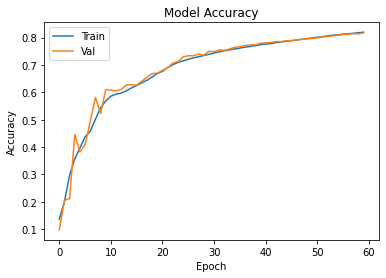

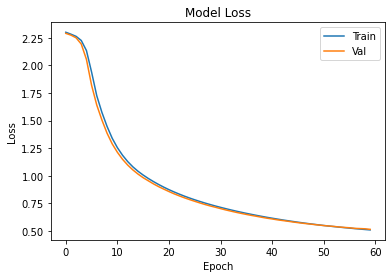

In [ ]:
inicio = time.time()
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation="sigmoid"),
    keras.layers.Dense(100, activation="sigmoid"),
    keras.layers.Dense(64, activation="sigmoid"),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(optimizer='sgd', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

entrenamiento = model.fit(x_train, y_train, batch_size=64, epochs=60, validation_split=0.2, verbose=0)

fin = time.time()
print("\nDuración en segundos:", fin - inicio)

print("\nLa accuracy en entrenamiento es: ", np.max(entrenamiento.history['accuracy']))
print("\nLa accuracy en validación es: ", np.max(entrenamiento.history['val_accuracy']))
print("\nLa accuracy del modelo con los datos del test es: ", model.evaluate(x_test, y_test)[1])

plot_acc(entrenamiento)
plot_loss(entrenamiento)


#### Unidades relu


Duración en segundos: 150.95967650413513

La accuracy en entrenamiento es:  0.9251041412353516

La accuracy en validación es:  0.8892499804496765
313/313 [==============================] - 1s 2ms/step - loss: 0.3878 - accuracy: 0.8640

La accuracy del modelo con los datos del test es:  0.8640000224113464


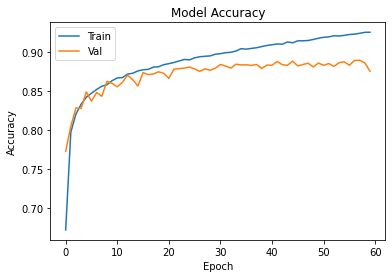

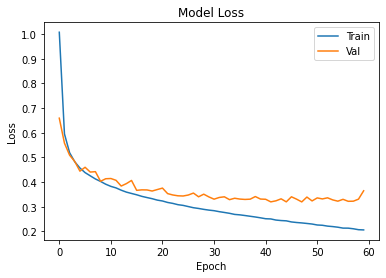

In [ ]:
inicio = time.time()
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(optimizer='sgd', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
entrenamiento2 = model.fit(x_train, y_train, batch_size=64, epochs=60, validation_split=0.2, verbose=0)

fin = time.time()
print("\nDuración en segundos:", fin - inicio)

print("\nLa accuracy en entrenamiento es: ", np.max(entrenamiento2.history['accuracy']))
print("\nLa accuracy en validación es: ", np.max(entrenamiento2.history['val_accuracy']))
print("\nLa accuracy del modelo con los datos del test es: ", model.evaluate(x_test, y_test)[1])

plot_acc(entrenamiento2)
plot_loss(entrenamiento2)


A continuación se muestran ambos modelos (sigmoid y relu), 

---

En las anteriores gráficas se pudo observar que al usar _sigmoid_ la precisión fue menor tanto para el entrenamiento como para los datos de test, en cambio, con _relu_, aunque el tiempo de procesamiento fue ligeramente mayor, la precisión fue mejor en ambas estadisticas.

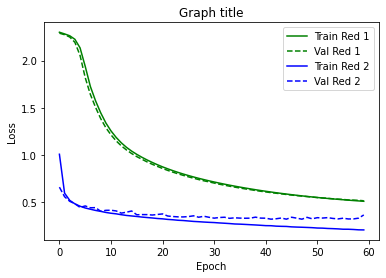

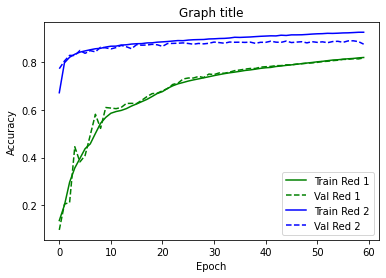

In [ ]:
plot_compare_losses(entrenamiento, entrenamiento2)
plot_compare_accs(entrenamiento, entrenamiento2)


## 2. Inicialización de parámetros

En este ejercicio, vamos a evaluar la importancia de una correcta inicialización de parámetros en una red neuronal.

**Ejercicio 2**: Partiendo de una red similar a la del ejercicio anterior (usando ya ReLUs), comentar las diferencias que se aprecian en el entrenamiento al utilizar distintas estrategias de inicialización de parámetros. Para ello, inicializar todas las capas con las siguientes estrategias, disponibles en Keras, y analizar sus diferencias:

* Inicialización con ceros.
* Inicialización con una variable aleatoria normal.
* Inicialización con los valores por defecto de Keras para una capa Dense (estrategia *glorot uniform*)

### Inicialización con ceros

Tiempo en segundos: 71.31346940994263

La accuracy en entrenamiento es:  0.10131250321865082

La accuracy en validación es:  0.09574999660253525
313/313 [==============================] - 1s 2ms/step - loss: 2.3026 - accuracy: 0.1000

La accuracy del modelo con los datos de test es:  0.10000000149011612




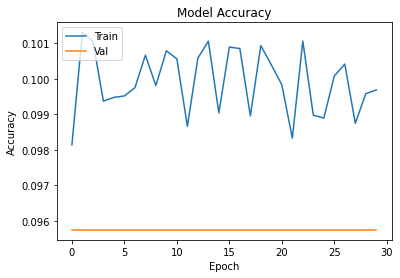

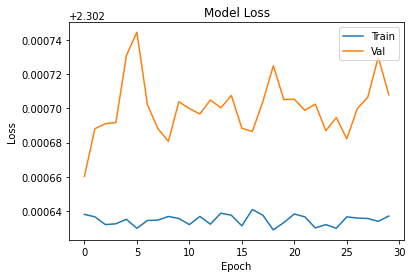

In [ ]:
inicio = time.time()
modelo = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)), 
    keras.layers.Dense(128, activation='relu', kernel_initializer='zero', bias_initializer='zero'),
    keras.layers.Dense(100, activation='relu', kernel_initializer='zero', bias_initializer='zero'),
    keras.layers.Dense(64, activation='relu', kernel_initializer='zero', bias_initializer='zero'),
    keras.layers.Dense(10, activation="softmax") 
])

modelo.compile(optimizer='sgd', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
modelo_fit = modelo.fit(x_train, y_train, batch_size=64, epochs=30, validation_split=0.2, verbose=0)

fin = time.time()
print("Tiempo en segundos:", fin - inicio)

print("\nLa accuracy en entrenamiento es: ", np.max(modelo_fit.history['accuracy']))
print("\nLa accuracy en validación es: ", np.max(modelo_fit.history['val_accuracy']))
print("\nLa accuracy del modelo con los datos de test es: ",modelo.evaluate(x_test, y_test)[1])

print("\n")
plot_acc(modelo_fit)
print("\n")
plot_loss(modelo_fit)

### Inicialización con una variable aleatoria normal.

Tiempo en segundos: 80.26599311828613

La accuracy en entrenamiento es:  0.8863958120346069

La accuracy en validación es:  0.8740833401679993
313/313 [==============================] - 1s 2ms/step - loss: 0.3982 - accuracy: 0.8615

La accuracy del modelo con los datos de test es:  0.8615000247955322




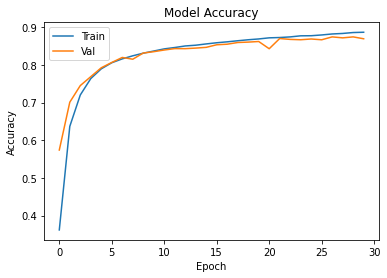

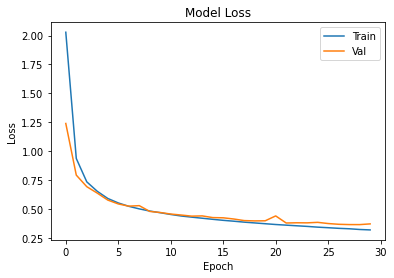

In [ ]:
inicio = time.time()
modelo = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu', kernel_initializer='random_uniform', bias_initializer='random_uniform'),
    keras.layers.Dense(100, activation='relu', kernel_initializer='random_uniform', bias_initializer='random_uniform'),
    keras.layers.Dense(64, activation='relu', kernel_initializer='random_uniform', bias_initializer='random_uniform'),
    keras.layers.Dense(10, activation='softmax') 
])

modelo.compile(optimizer='sgd', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

modelo_fit_2 = modelo.fit(x_train, y_train, batch_size=64, epochs=30, validation_split=0.2, verbose=0)

fin = time.time()
print("Tiempo en segundos:", fin - inicio)

print("\nLa accuracy en entrenamiento es: ", np.max(modelo_fit_2.history['accuracy']))
print("\nLa accuracy en validación es: ", np.max(modelo_fit_2.history['val_accuracy']))
print("\nLa accuracy del modelo con los datos de test es: ",modelo.evaluate(x_test, y_test)[1])
print("\n")
plot_acc(modelo_fit_2)
print("\n")
plot_loss(modelo_fit_2)

### Inicialización con los valores por defecto

Tiempo en segundos: 86.45615458488464

La accuracy en entrenamiento es:  0.8974999785423279

La accuracy en validación es:  0.8796666860580444
313/313 [==============================] - 1s 2ms/step - loss: 0.3614 - accuracy: 0.8748

La accuracy del modelo con los datos de test es:  0.8748000264167786




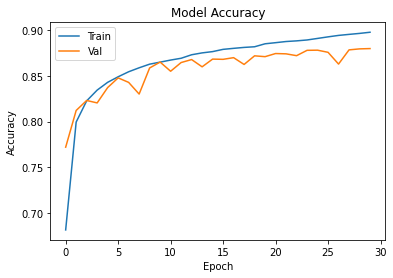

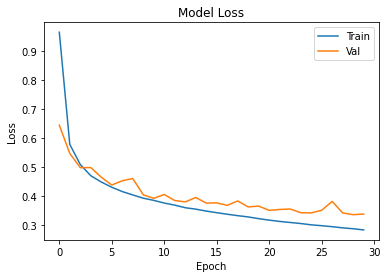

In [ ]:
inicio = time.time()
modelo = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10, activation='softmax')])

modelo.compile(optimizer='sgd', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
modelo_fit_3 = modelo.fit(x_train, y_train, batch_size=64, epochs=30, validation_split=0.2, verbose=0)

fin = time.time()
print("Tiempo en segundos:", fin - inicio)

print("\nLa accuracy en entrenamiento es: ", np.max(modelo_fit_3.history['accuracy']))
print("\nLa accuracy en validación es: ", np.max(modelo_fit_3.history['val_accuracy']))
print("\nLa accuracy del modelo con los datos de test es: ",modelo.evaluate(x_test, y_test)[1])
print("\n")
plot_acc(modelo_fit_3)
print("\n")
plot_loss(modelo_fit_3)


#### Comentarios
La inicialización por ceros proporciona una baja precisión debido a que todos las capas tienen el mismo gradiente durante el back-propagation y por esa razón durante el proceso todos los valores cambian de la misma forma.

La inicialización a partir de una variable aleatorio y la que utiliza los valores por defecto dan precisiones similares aunque la precision por defecto es ligeramente superior.

En el tema del rendimiento podemos observar que la inicialización por defecto es un poco más lenta que las otras dos opciones, donde, la inicializa de ceros es la más rápida.

## 3. Optimizadores

**Ejercicio 3**: Partiendo de una red similar a la del ejercicio anterior (utilizando la mejor estrategia de inicialización observada), comparar y analizar las diferencias que se observan  al entrenar con varios de los optimizadores vistos en clase, incluyendo SGD como optimizador básico (se puede explorar el espacio de hiperparámetros de cada optimizador, aunque para optimizadores más avanzados del estilo de adam y RMSprop es buena idea dejar los valores por defecto provistos por Keras).

### SGD

Tiempo en segundos: 56.64390301704407

La accuracy en entrenamiento es:  0.8864374756813049

La accuracy en validación es:  0.8734999895095825
313/313 [==============================] - 1s 2ms/step - loss: 0.3736 - accuracy: 0.8663

La accuracy del model con los datos de test es:  0.8662999868392944




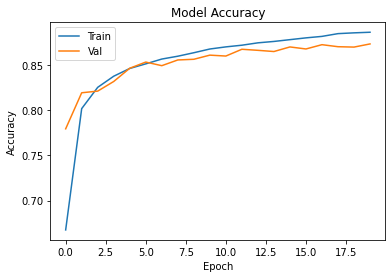

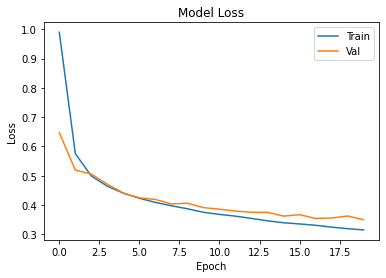

In [ ]:
inicio = time.time()
modelo = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

modelo.compile(optimizer='sgd', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

modelo_fit = modelo.fit(x_train, y_train, batch_size=64, epochs=20, validation_split=0.2, verbose=0)

fin = time.time()
print("Tiempo en segundos:", fin - inicio)

print("\nLa accuracy en entrenamiento es: ", np.max(modelo_fit.history['accuracy']))
print("\nLa accuracy en validación es: ", np.max(modelo_fit.history['val_accuracy']))
print("\nLa accuracy del model con los datos de test es: ",modelo.evaluate(x_test, y_test)[1])
print("\n")
plot_acc(modelo_fit)
print("\n")
plot_loss(modelo_fit)

### Adam

Tiempo en segundos: 82.51814651489258

La accuracy en entrenamiento es:  0.932604193687439

La accuracy en validación es:  0.8916666507720947
313/313 [==============================] - 1s 2ms/step - loss: 0.3776 - accuracy: 0.8833

La accuracy del model con los datos de test es:  0.8833000063896179




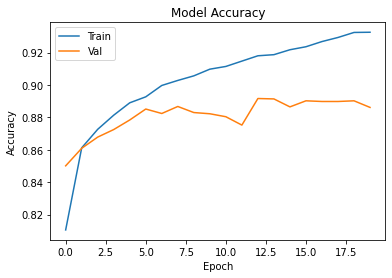

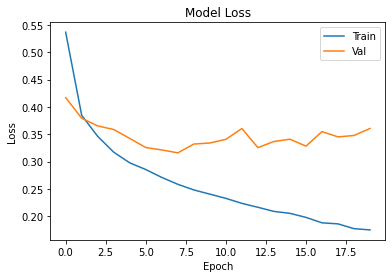

In [ ]:
inicio = time.time()
modelo = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

modelo.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

modelo_fit = modelo.fit(x_train, y_train, batch_size=64, epochs=20, validation_split=0.2, verbose=0)

fin = time.time()
print("Tiempo en segundos:", fin - inicio)

print("\nLa accuracy en entrenamiento es: ", np.max(modelo_fit.history['accuracy']))
print("\nLa accuracy en validación es: ", np.max(modelo_fit.history['val_accuracy']))
print("\nLa accuracy del model con los datos de test es: ",modelo.evaluate(x_test, y_test)[1])
print("\n")
plot_acc(modelo_fit)
print("\n")
plot_loss(modelo_fit)

### RMSprop

Tiempo en segundos: 82.61425471305847

La accuracy en entrenamiento es:  0.9158958196640015

La accuracy en validación es:  0.8892499804496765
313/313 [==============================] - 1s 2ms/step - loss: 0.4964 - accuracy: 0.8708

La accuracy del model con los datos de test es:  0.8708000183105469




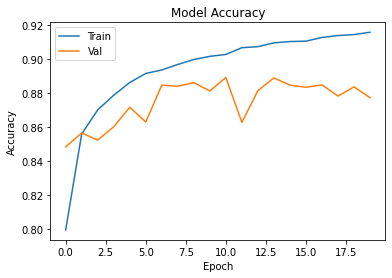

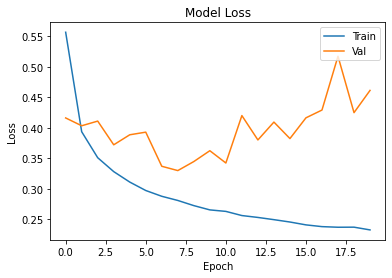

In [ ]:
inicio = time.time()
modelo = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

modelo.compile(optimizer='rmsprop', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

modelo_fit = modelo.fit(x_train, y_train, batch_size=64, epochs=20, validation_split=0.2, verbose=0)

fin = time.time()
print("Tiempo en segundos:", fin - inicio)

print("\nLa accuracy en entrenamiento es: ", np.max(modelo_fit.history['accuracy']))
print("\nLa accuracy en validación es: ", np.max(modelo_fit.history['val_accuracy']))
print("\nLa accuracy del model con los datos de test es: ",modelo.evaluate(x_test, y_test)[1])
print("\n")
plot_acc(modelo_fit)
print("\n")
plot_loss(modelo_fit)

El optimizador Adam da una mejor precisión de igual forma que el optimizador RMSprop si se compara con el optimizador SGD.
El optimizador Adam es uno de los que brinda peor rendimiento pero la mejor precisión.

## 4. Regularización y red final

**Ejercicio 4.1**: Entrenar una red final que sea capaz de obtener una accuracy en el validation set cercana al 90%. Para ello, combinar todo lo aprendido anteriormente y utilizar técnicas de regularización para evitar overfitting. Algunos de los elementos que pueden tenerse en cuenta son los siguientes.

* Número de capas y neuronas por capa
* Optimizadores y sus parámetros
* Batch size
* Unidades de activación
* Uso de capas dropout, regularización L2, regularización L1...
* Early stopping (se puede aplicar como un callback de Keras, o se puede ver un poco "a ojo" cuándo el modelo empieza a caer en overfitting y seleccionar el número de epochs necesarias)
* Batch normalization

Si los modelos entrenados anteriormente ya se acercaban al valor requerido de accuracy, probar distintas estrategias igualmente y comentar los resultados.

Explicar brevemente la estrategia seguida y los modelos probados para obtener el modelo final, que debe verse entrenado en este Notebook. No es necesario guardar el entrenamiento de todos los modelos que se han probado, es suficiente con explicar cómo se ha llegado al modelo final.

Epoch 9: early stopping
Time (in seconds): 79.3013596534729
La accuracy en entrenamiento es:  0.9307708144187927
La accuracy en validación es:  0.8900833129882812


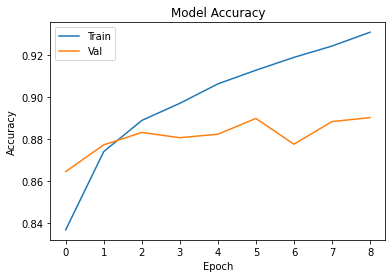

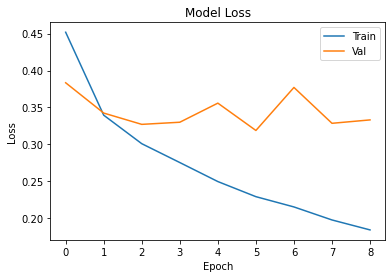

In [ ]:
inicio = time.time()
modelo = keras.Sequential([
    
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])
e = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
modelo.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
modelo_fit = modelo.fit(x_train, y_train, batch_size=64, epochs=20, validation_split=0.2, callbacks=[e], verbose=0)

fin = time.time()
print("Time (in seconds):", fin - inicio)
print("La accuracy en entrenamiento es: ", np.max(modelo_fit.history['accuracy']))
print("La accuracy en validación es: ", np.max(modelo_fit.history['val_accuracy']))
plot_acc(modelo_fit)
plot_loss(modelo_fit)

### Evaluación del modelo en datos de test

Una vez elegido el que creemos que es nuestro mejor modelo a partir de la estimación que hemos visto en los datos de validación, es hora de utilizar los datos de test para ver cómo se comporta nuestro modelo ante nuevos datos. Si hemos hecho bien las cosas, este número debería ser parecido al valor de nuestra estimación vista en los datos de validación.

**Pregunta 4.2**. Utilizando nuestro mejor modelo, obtener la accuracy resultante en el dataset de test. Comentar este resultado.

In [ ]:
print("La accuracy del modelo con los datos de test es: ", modelo.evaluate(x_test, y_test)[1])


313/313 [==============================] - 1s 3ms/step - loss: 0.3509 - accuracy: 0.8847
La accuracy del modelo con los datos de test es:  0.8847000002861023


#### Comentario
Se debe tener en cuenta que la precisión obtenida se acerca demasiado a los valores usados en la validación pero son diferentes a los resultados mostrados por los datos de entrenamiento, por esa razón, que el modelo tiene un overfitting pero la precisión resultante es alrededor de 88% que se acerca demasiado al 90%.

Enlace al colab:

[COLAB - El archivo ipynb](https://colab.research.google.com/drive/1yq35afvQxbr3ELUb_LKsS-edb1Y04ygP?usp=sharing)